In [11]:
import argparse
import os
import sys
import tabulate
import time
import torch
import torch.nn.functional as F

import curves
import data
import models
import utils
import pickle

import copy
import torchvision

In [2]:
architecture = getattr(models, "VGG16")

In [3]:
architecture

models.vgg.VGG16

In [4]:
model = architecture.base(num_classes=10, **architecture.kwargs)

In [5]:
loaders, num_classes = data.loaders(
    "MNIST",
    "data",
    128,
    1,
    "VGG",
    False
)

Processing...
Done!
Using train (45000) + validation (5000)


In [6]:
for X, y in loaders['test']:
    break

In [15]:
loaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x15162b3860>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x15162a8e80>}

In [8]:
X.shape

torch.Size([128, 1, 28, 28])

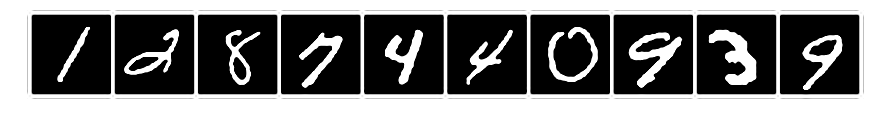

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline

def show_images(x, scale=15, line_width=10):
    plt.figure(figsize=(scale, scale / line_width * (x.shape[0] // line_width + 1)))
    x = x.view(-1, 1, 28, 28)
    mtx = torchvision.utils.make_grid(x, nrow=line_width, pad_value=1)
    plt.imshow(mtx.permute([1, 2, 0]).numpy(), cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
    plt.axis('off')

show_images(X[:10])

In [66]:
y_pred = torch.argmax(model(X), dim=-1)

In [67]:
y

tensor([ 7,  1,  4,  1,  0,  2,  2,  5,  9,  6,  0,  1,  3,  1,
         1,  2,  1,  8,  5,  6,  9,  2,  4,  2,  8,  8,  3,  7,
         1,  7,  1,  7,  5,  9,  7,  0,  7,  8,  3,  6,  1,  2,
         2,  5,  9,  8,  4,  8,  9,  4,  2,  5,  9,  3,  7,  9,
         9,  3,  7,  9,  2,  7,  8,  9,  0,  7,  3,  0,  1,  7,
         1,  4,  6,  8,  2,  3,  4,  1,  6,  2,  6,  0,  3,  5,
         1,  0,  9,  7,  0,  0,  9,  3,  4,  9,  8,  8,  0,  1,
         6,  1,  4,  9,  0,  7,  8,  1,  0,  9,  5,  2,  4,  4,
         7,  0,  4,  8,  9,  3,  1,  2,  2,  4,  4,  0,  4,  5,
         1,  7])

In [68]:
y_pred

tensor([ 4,  5,  4,  4,  4,  5,  4,  4,  5,  3,  5,  4,  4,  4,
         2,  4,  2,  4,  4,  4,  2,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  0,  4,  4,  4,  2,  4,  4,  4,  4,  4,
         4,  4,  0,  5,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  2,  4,  2,
         4,  3,  3,  2,  4,  4,  3,  4,  4,  4,  3,  4,  4,  4,
         3,  4,  2,  4,  4,  4,  2,  4,  4,  4,  4,  4,  4,  4,
         4,  2,  4,  4,  3,  4,  3,  4,  3,  4,  3,  2,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  2])

In [69]:
model

VGGBase(
  (layer_blocks): ModuleList(
    (0): ModuleList(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ModuleList(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): ModuleList(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): ModuleList(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (4): ModuleList(
      (0): Conv2d(512, 512, kernel_size=(3, 3), 

## Rescale

In [50]:
def rescale(l, scale):
    list(model.modules())[l].weight=torch.nn.Parameter(list(model.modules())[l].weight*scale)
    list(model.modules())[l].bias=torch.nn.Parameter(list(model.modules())[l].bias*scale)

In [58]:
list(model.modules())[18]

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [52]:
rescale(-3, 10)

In [53]:
rescale(-6, 0.1)

In [54]:
y_pred_r = torch.argmax(model(X), dim=-1)

In [55]:
y_pred_r

tensor([ 8,  8,  8,  8,  8,  3,  8,  3,  3,  8,  8,  3,  8,  8,
         3,  3,  8,  3,  8,  8,  3,  8,  8,  8,  8,  8,  8,  3,
         8,  8,  8,  3,  3,  8,  8,  8,  8,  3,  8,  8,  8,  8,
         8,  3,  3,  8,  8,  3,  8,  8,  8,  3,  8,  8,  8,  8,
         8,  8,  8,  3,  8,  8,  8,  8,  8,  8,  8,  3,  8,  8,
         8,  8,  3,  3,  8,  8,  8,  8,  8,  3,  3,  8,  8,  8,
         3,  3,  8,  8,  8,  8,  3,  8,  8,  8,  8,  3,  3,  8,
         8,  3,  3,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  3,  3,  8,  8,
         3,  8])

In [56]:
sum(~(y_pred==y_pred_r))

tensor(83, dtype=torch.uint8)

## Node

In [53]:
def change_node(l1, l2, i, j):
    
    c = copy.deepcopy(torch.nn.Parameter(list(model.modules())[l1].weight[j]))
    list(model.modules())[l1].weight[j]  = list(model.modules())[l1].weight[i] 
    list(model.modules())[l1].weight[i] = c
    
    c = copy.deepcopy(torch.nn.Parameter(list(model.modules())[l2].weight.transpose(0,1)[j]))
    list(model.modules())[l2].weight.transpose(0,1)[j]  = list(model.modules())[l2].weight.transpose(0,1)[i]
    list(model.modules())[l2].weight.transpose(0,1)[i] = c
    
 

In [54]:
change_node(-3, -1, 0, 1)

In [55]:
y_pred_n = torch.argmax(model(X), dim=-1)

In [56]:
y_pred_n

tensor([ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8])

In [62]:
print("eq ", ~(y_pred_n==y_pred_r))

eq  tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0], dtype=torch.uint8)


## Saving

In [71]:
#  torch.load("curve/checkpoint-50.pt")

In [74]:
for path, k in [("Aaa", 0), ("Bbb", 4 - 1)]:
    print('p ', path)
    print('k', k)
    

p  Aaa
k 0
p  Bbb
k 3


In [77]:
a = list(range(10))
a[::3]

[0, 3, 6, 9]

In [70]:
architecture = getattr(models, "VGG16")
curve = getattr(curves, 'PolyChain')

In [71]:
curve

curves.PolyChain

In [72]:
architecture.curve

models.vgg.VGGCurve

In [73]:
architecture.kwargs

{'batch_norm': False, 'depth': 16}

In [74]:
model = curves.CurveNet(
        10,
        curve,
        architecture.curve,
        3,
        True,
        True,
        architecture_kwargs=architecture.kwargs,
    )

In [75]:
model

CurveNet(
  (coeff_layer): PolyChain()
  (net): VGGCurve(
    (layer_blocks): ModuleList(
      (0): ModuleList(
        (0): Conv2d()
        (1): Conv2d()
      )
      (1): ModuleList(
        (0): Conv2d()
        (1): Conv2d()
      )
      (2): ModuleList(
        (0): Conv2d()
        (1): Conv2d()
        (2): Conv2d()
      )
      (3): ModuleList(
        (0): Conv2d()
        (1): Conv2d()
        (2): Conv2d()
      )
      (4): ModuleList(
        (0): Conv2d()
        (1): Conv2d()
        (2): Conv2d()
      )
    )
    (activation_blocks): ModuleList(
      (0): ModuleList(
        (0): ReLU(inplace)
        (1): ReLU(inplace)
      )
      (1): ModuleList(
        (0): ReLU(inplace)
        (1): ReLU(inplace)
      )
      (2): ModuleList(
        (0): ReLU(inplace)
        (1): ReLU(inplace)
        (2): ReLU(inplace)
      )
      (3): ModuleList(
        (0): ReLU(inplace)
        (1): ReLU(inplace)
        (2): ReLU(inplace)
      )
      (4): ModuleList(
        (

In [76]:
curve_parameters = list(model.net.parameters())

In [87]:
len(curve_parameters)

96

In [88]:
for i, p in enumerate(curve_parameters):
    print(i, p.shape)

0 torch.Size([64, 3, 3, 3])
1 torch.Size([64, 3, 3, 3])
2 torch.Size([64, 3, 3, 3])
3 torch.Size([64])
4 torch.Size([64])
5 torch.Size([64])
6 torch.Size([64, 64, 3, 3])
7 torch.Size([64, 64, 3, 3])
8 torch.Size([64, 64, 3, 3])
9 torch.Size([64])
10 torch.Size([64])
11 torch.Size([64])
12 torch.Size([128, 64, 3, 3])
13 torch.Size([128, 64, 3, 3])
14 torch.Size([128, 64, 3, 3])
15 torch.Size([128])
16 torch.Size([128])
17 torch.Size([128])
18 torch.Size([128, 128, 3, 3])
19 torch.Size([128, 128, 3, 3])
20 torch.Size([128, 128, 3, 3])
21 torch.Size([128])
22 torch.Size([128])
23 torch.Size([128])
24 torch.Size([256, 128, 3, 3])
25 torch.Size([256, 128, 3, 3])
26 torch.Size([256, 128, 3, 3])
27 torch.Size([256])
28 torch.Size([256])
29 torch.Size([256])
30 torch.Size([256, 256, 3, 3])
31 torch.Size([256, 256, 3, 3])
32 torch.Size([256, 256, 3, 3])
33 torch.Size([256])
34 torch.Size([256])
35 torch.Size([256])
36 torch.Size([256, 256, 3, 3])
37 torch.Size([256, 256, 3, 3])
38 torch.Size([2

In [81]:
model.net.parameters()

<generator object Module.parameters at 0x151b1c9a40>

In [89]:
a = np.array([1,4,5,7])

In [95]:
a[(a>3)*(a<7)]

array([4, 5])

In [94]:
pred = model(X)

In [95]:
pred.shape

torch.Size([128, 10])

In [96]:
from torch.nn import Module

In [98]:
m = Module()

In [105]:
m.register_buffer('range', torch.arange(0, float(3)))

In [106]:
m.range

tensor([ 0.,  1.,  2.])

In [122]:
t_n = 2/3 * (3 - 1)
torch.max(m.range.new([0.0]), 1.0 - torch.abs(t_n - m.range))

tensor([ 0.0000,  0.6667,  0.3333])